# NAVEGACION 3D Y RECONOCIMIENTO DE IMAGENES

Se pesenta reducción de la dimensionalidad y el aprendizaje no supervisado. Utilizaré el conjunto de datos MNIST proporcionado por Kaggle para entrenar un SOM y proyectar los dígitos escritos a mano en un mapa bidimensional que (con suerte) conserva la propiedad topológica del conjunto de datos original. Aunque se pueden usar varios métodos alternativos para obtener resultados competitivos en menos tiempo (en particular, se sabe que el aprendizaje supervisado con CNN es extremadamente efectivo), la naturaleza visual del conjunto de datos y la fácil interpretación de sus elementos (dígitos manuscritos comunes) es ideal para explorar las capacidades de este método y comprender cómo funciona el SOM.

Este cuaderno se inspiró en la Introducción interactiva a la reducción de la dimensionalidad, por Anisotropic, donde se presentan varios métodos comunes de reducción de dimensionalidad y agrupamiento.

## Preparando la data

In [1]:
#Como de costumbre se comienza a importar una serie de bibliotecas que seran de ayuda mas adelante.

import numpy as np 
import pandas as pd 
import seaborn as sns
from imageio import imwrite
#from scipy.misc import imsave
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.preprocessing import StandardScaler
from PIL import Image, ImageChops

We will use here SimpSOM, a python library for SOM freely available on [PyPI](https://pypi.python.org/pypi/SimpSOM) and [Github](https://github.com/fcomitani/SimpSOM). 

In [2]:
import SimpSOM as sps

Para ayudar a la convergencia del mapa, es una buena idea limitar el número de puntos en los que se realizará el entrenamiento. Por lo tanto, deberíamos elegir un número limitado de puntos de referencia que posiblemente representen la distribución de toda la población en el espacio de alta dimensionalidad. En nuestro caso, podemos suponer que la distribución es uniforme en los diez dígitos, luego podemos elegir al azar un subconjunto de estos para el entrenamiento. Sin embargo, es importante señalar que, aunque un mayor número de puntos de entrenamiento, en teoría, aumentan la precisión del mapeo al tener en cuenta una mayor variabilidad en las imágenes, también podría complicar el proceso de mapeo e impedir su convergencia. . ¡A veces solo necesitas un poco menos de datos!

Aquí, seleccionaremos solo 500 puntos. Comprobemos que efectivamente están distribuidos por igual. También es una buena idea arreglar la semilla aleatoria para reproducibilidad y depuración ya que los resultados finales del mapeo dependerán de su valor.

Como se muestra en otros núcleos, los datos de las imágenes se despliegan en matrices de 28 * 28, con cada elemento que contiene un único valor de color de píxel en blanco y negro. Lo mantendremos así y normalizaremos las matrices para mejorar el aprendizaje del mapa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



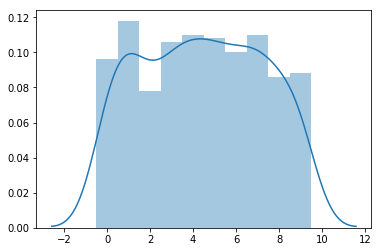

In [3]:
np.random.seed(0)

# Cargamos aquí los datos del conjunto de entrenamiento proporcionado, seleccionamos al azar 500 puntos de referencia y separamos las etiquetas.
train = pd.read_csv('D:/python/imagenes/train.csv')
train = train.sample(n=500, random_state=0)
labels = train['label']
train = train.drop("label",axis=1)

# Tracemos la distribución y veamos si es uniforme
sns.distplot(labels.values,bins=np.arange(-0.5,10.5,1))

#Then we normalize the data, a crucial step to the correct functioning of the SOM algorithm
trainSt = StandardScaler().fit_transform(train.values)

The resulting distribution is not great, but it's what we can expect by taking only 500 points. It will have to do.

## ENTRENANDO EL MAPA

Ahora podemos proceder al configurar un mapa y entrenarlo con nuestros puntos de referencia.

Primero, necesitamos construir una red, puede ser tan grande como uno quiera, pero debe contener al menos suficientes nodos para mapear todos nuestros puntos de referencia separados, posiblemente más. Obviamente, un mapa más grande permite distinguir características topográficas más sutiles, pero tiene un costo, ya que el tiempo de cálculo aumenta con cada nodo agregado.

Una vez más, dados los recursos limitados disponibles en los kernels interactivos, construiremos un mapa de 40x40 y lo entrenaremos solo durante 5000 épocas (una buena regla general es realizar un ciclo de al menos 10 veces el número de puntos de entrenamiento) con un nivel relativamente alto tasa de aprendizaje inicial de 0.1. Activamos condiciones de contorno periódicas para evitar artefactos en los bordes y elegimos PCA como inicialización de pesos. Los pesos de los nodos se pueden elegir aleatoriamente a partir de una distribución uniforme dentro de los valores mínimo y máximo de nuestro conjunto de datos de entrenamiento (¡bueno que lo normalizamos de antemano!) O del espacio abarcado por los dos primeros vectores PCA. Elegimos aquí lo último, ya que puede ayudar a que el mapa converja más rápido.

Con estos parámetros, todavía demorará alrededor de 6 horas en la CPU de Kaggle.

Periodic Boundary Conditions active.
The weights will be initialised with PCA.
Training SOM... done!


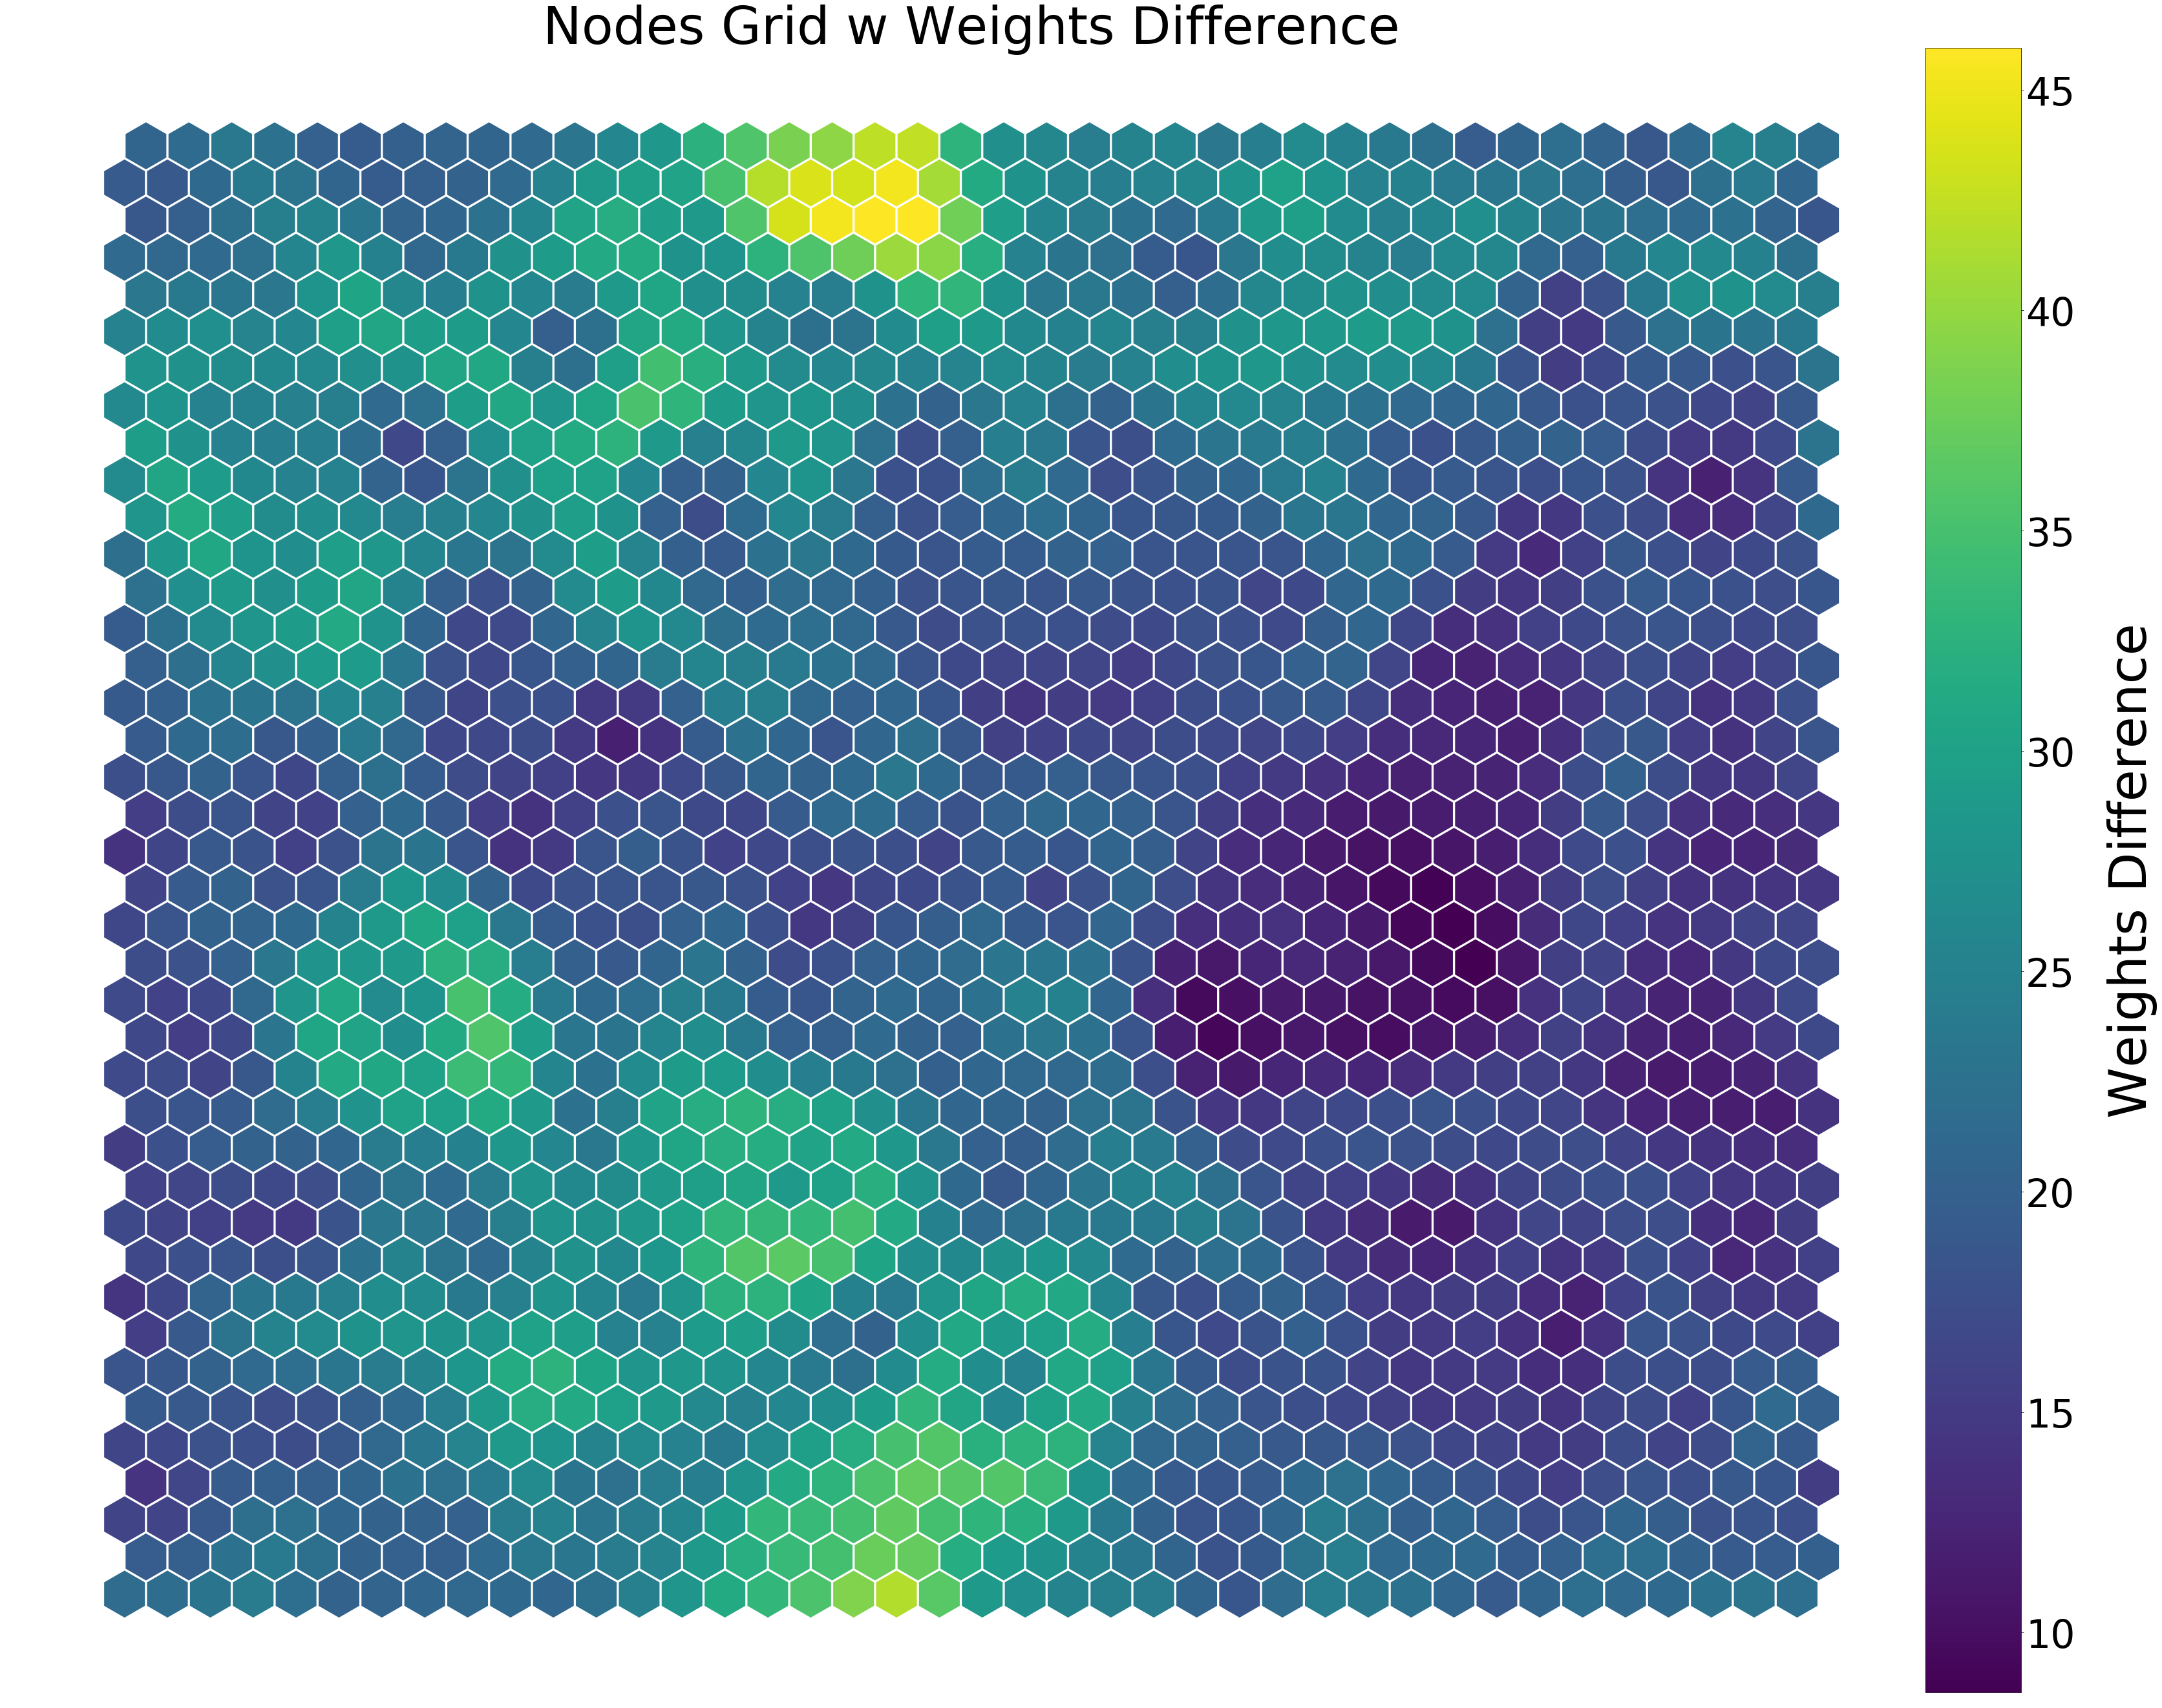

In [4]:
# Construimos una red de 40x40 e inicializamos sus pesos con PCA
net = sps.somNet(40, 40, trainSt, PBC=True, PCI=True)

# Ahora podemos entrenarlo con una tasa de aprendizaje de 0.1 para 10000 épocas
net.train(0.1, 10000)

# Imprimimos para examinar el mapa con las diferencias de pesos entre los nodos, esto nos ayudará a identificar los centros de clúster 
net.diff_graph(show=True,printout=True)

¡Bonito! Ahora tenemos un mapa capacitado, pero tenemos que entender lo que significa. En la trama sobre el color, la escala va de azul oscuro a amarillo para los nodos cuyos pesos de vecinos son menos o más distantes (o simplemente diferentes) respectivamente. Esto significa que las áreas más oscuras representan cuencas de clúster donde todos los nodos vecinos son similares, mientras que las áreas amarillas son regiones de bordes de alta diferencia entre cuencas. ¡Solo piensa en montañas y valles!
## VISUALIZAMOS LOS RESULTADOS

Lo que necesitamos hacer ahora es simplemente proyectar nuestros datos (cualquier información de MNIST) en el mapa y ver dónde se mapea cada imagen. En nuestro caso, la interpretación de los datos es relativamente fácil, ya que todas nuestras imágenes están etiquetadas con la categoría correspondiente . En los proyectos de aprendizaje sin supervisión, donde no se conocen las etiquetas, esto puede ser difícil y una simple inspección visual puede ser problemática. Un buen enfoque puede ser extraer los vectores ponderados de los nodos del centro de la cuenca y verlos como imágenes de 28x28. Aquí podemos hacerlo por algunas cuencas y ver que de hecho son arquetipos de dígitos específicos: ¡funciona!

In [5]:
# Aquí primero definimos algunas funciones útiless
def autocrop(fileName):
    im = Image.open(fileName)
    im=im.crop((0,100,2900,im.size[1]))
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

def posMap(x,y):
     if y%2==0:
        return [y, x*2/np.sqrt(3)*3/4]
     else:
        return [y+0.5, x*2/np.sqrt(3)*3/4]
    
def posCount(x,y):
     return y*40+x

def posCountR(x):
     return [np.int(x%40),np.int(x/40)]

Node's position: 0 20


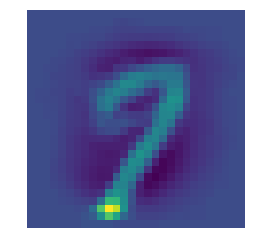

Node's position: 6 1


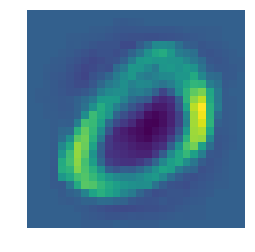

Node's position: 11 23


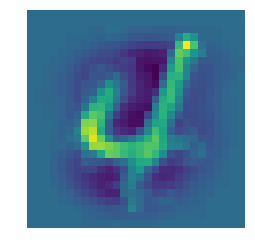

Node's position: 31 18


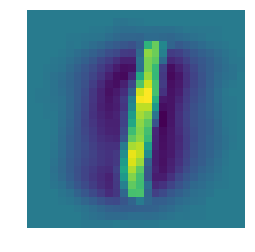

Node's position: 33 7


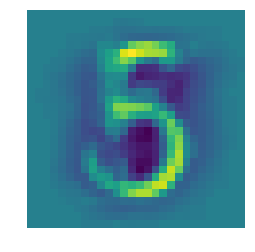

Node's position: 37 13


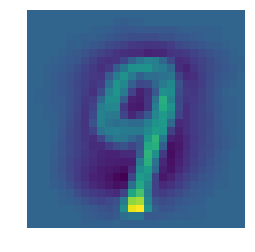

In [6]:
# Imprimamos algunos pesos de nodos entrenados y veamos qué tan buenos son
listNodes=[[20,0],[23,11],[1,6],[13,37],[7,33],[18,31]]
listCount=[posCount(20,0), posCount(23,11), posCount(1,6), posCount(13,37), posCount(7,33), posCount(18,31)]

i=0
for node in net.nodeList:
    if i in listCount:
        print('Node\'s position: {:d} {:d}'.format(posCountR(i)[1], posCountR(i)[0]) )
        plt.imshow(np.asarray(node.weights).reshape(28,28))
        plt.axis('off')
        plt.show()
    i+=1

As expected, some of them are quite similar to specific digits archetypes, while others still contain generic and undefined shapes, either because they lay closer to a border region between different categorical clusters, or simply because in need of more training.
Let's now map our training points to see where they ended up by matching them with their closest node. We map the results interactively with plotly, hovering on each point with the mouse we can see the original label. To help visualize the clusters, each label has been colored differently in the scatter plot.

In [7]:
projData=net.project(trainSt[:500])

In [8]:
# Primero guardamos una versión recortada del mapa original para superponer y luego agregamos los puntos de dispersión
cropped = autocrop('nodesDifference.png')
cropped.save('cropped.png')

In [9]:
#Y aquí preparamos el gráfico de la trama.
trace0 = go.Scatter(
    x = [x for x,y in projData],
    y = [y for x,y in projData],
#    name = labels,
    hoveron = [str(n) for n in labels],
    text = [str(n) for n in labels],
    mode = 'markers',
    marker = dict(
        size = 8,
        color = labels,
        colorscale ='Jet',
        showscale = False,
        opacity = 1
    ),
    showlegend = False

)
data = [trace0]

layout = go.Layout(
    images= [dict(
                  source= "cropped.png",
                  xref= "x",
                  yref= "y",
                  x= -0.5,
                  y= 39.5*2/np.sqrt(3)*3/4,
                  sizex= 40.5,
                  sizey= 40*2/np.sqrt(3)*3/4,
                  sizing= "stretch",
                  opacity= 0.5,
                  layer= "below")],
    width = 800,
    height = 800,
    hovermode= 'closest',
    xaxis= dict(
        range=[-1,41],
        zeroline=False,
        showgrid=False,
        ticks='',
        showticklabels=False
    ),
    yaxis=dict(
        range=[-1,41],
        zeroline=False,
        showgrid=False,
        ticks='',
        showticklabels=False
    ),
    showlegend= True
)


fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')

Nice! The algorithm is able to clearly separate in clusters some of our categories. Their centers are mostly found in the "basins" where the weights difference is minimal (in dark blue). The topology of the high dimensionality space is also somehow respected, with similar shapes mapped closed together (e.g. handwritten 7 and 9) and others far apart (such 1 and 0).  Unfortunately, however, the accuracy is not great, as there are a number of outliers. This issue could be easily solved by fine-tuning the algorithm parameters, with further training and a better representative set of landmark points. Introducing more variability in the training set, by adding random rotations and translations, could really make the difference.



## CONCLUSION



Self-Organizing Maps represent an interesting alternative to more commonly used unsupervised learning and dimensionality reduction algorithms. Visualizing the topology of the dataset can be helpful in identifying hidden patterns and relationships between clusters of datapoints. The algorithm can be easily extended and used in conjunction with other methods (such as PCA to initialize the weights or k-means to cluster the projected data on top of the map) to tackle more challenging problems. 